# Practicalities #
In this session we will look at a number of practical issues relevant to the use of neural networks.

In [2]:
%matplotlib inline
import numpy as np
np.random.seed(1)
import tensorflow as tf
tf.random.set_seed(1)
import matplotlib.pyplot as plt
from sklearn.datasets import make_moons
from sklearn.model_selection import train_test_split
from keras import models, layers, optimizers, initializers, backend
from keras.datasets import mnist, reuters
from keras.utils import to_categorical
print('Done')

Done


#### Obtain and visualize data

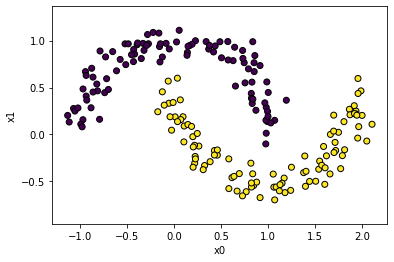

In [3]:
X_train,y_train = make_moons(n_samples=200,noise = 0.1, random_state=3)
plt.scatter(X_train[:, 0], X_train[:, 1], marker='o', c=y_train, edgecolor='k')
plt.xlabel('x0')
plt.ylabel('x1')
plt.axis('equal');

## The effect of varying step size ##

In [4]:
step_sizes = [0.5,0.2,0.1,0.01]
train_errors = {}

for step_size in step_sizes:
    np.random.seed(3)
    tf.random.set_seed(3)    
    network = models.Sequential()
    network.add(layers.Dense(20, activation='relu', input_dim=2))
    network.add(layers.Dense(5, activation='relu'))
    network.add(layers.Dense(5, activation='relu'))
    network.add(layers.Dense(1, activation='sigmoid'))
    opt = optimizers.SGD(step_size)
    network.compile(optimizer=opt, loss='binary_crossentropy', metrics=['accuracy'])
    history = network.fit(X_train,y_train, epochs=200, verbose = 0, batch_size=len(X_train))
    train_errors[step_size] = history.history['loss']
print('Done')

Done


In [5]:
# set up the line styles to use
from cycler import cycler
colors = plt.rcParams['axes.prop_cycle'].by_key()['color']
default_cycler = (cycler(color=colors) +
                  cycler(linestyle=['-', '--', ':', '-.','-', '--', ':', '-.','-', '--']))
plt.rc('axes', prop_cycle=default_cycler)

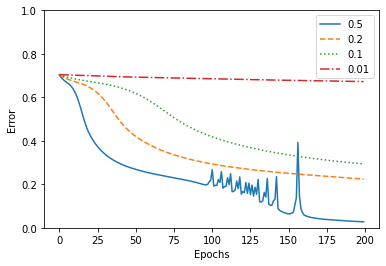

In [6]:
lines = plt.plot(np.array(list(train_errors.values())).transpose())
#plt.title('Training errors')
plt.xlabel('Epochs')
plt.ylabel('Error')
plt.ylim([0,1])
plt.legend(lines[:], step_sizes, loc='upper right')


plt.savefig('stepsizes.png')
plt.show();

## The effect of varying batch size ##

In [7]:
batch_sizes = [64,200,32,8,1]
train_errors = {}
times = {}
step_size = 0.2
epochs = 200
    
for batch_size in batch_sizes:
    np.random.seed(3)
    tf.random.set_seed(3)    
    network = models.Sequential()
    network.add(layers.Dense(20, activation='relu', input_dim=2))
    network.add(layers.Dense(5, activation='relu'))
    network.add(layers.Dense(5, activation='relu'))
    network.add(layers.Dense(1, activation='sigmoid'))
    opt = optimizers.SGD(step_size)
    network.compile(optimizer=opt, loss='binary_crossentropy', metrics=['accuracy'])
    print('\n',batch_size)
    %time history = network.fit(X_train,y_train, epochs=epochs, verbose = 0, batch_size=batch_size)
    train_errors[batch_size] = history.history['loss']
print('Done')


 64
Wall time: 657 ms

 200
Wall time: 389 ms

 32
Wall time: 967 ms

 8
Wall time: 1.7 s

 1
Wall time: 11.3 s
Done


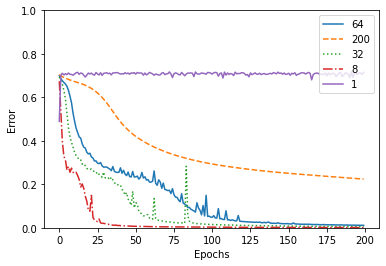

In [8]:
lines = plt.plot(np.array(list(train_errors.values())).transpose())
plt.xlabel('Epochs')
plt.ylabel('Error')
plt.ylim([0,1])
plt.legend(lines[:], batch_sizes, loc='upper right')


plt.savefig('batchsizes1.png')
plt.show();

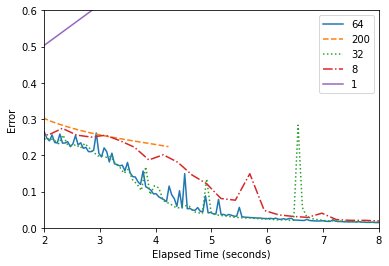

In [9]:
epoch = np.array(range(1,epochs+1)).reshape((-1,1))
total_times = [9.32,4.23,15.6,51.7,376]
times = np.repeat(epoch, len(batch_sizes), axis=1)*total_times/len(X_train)
lines = plt.plot(times,np.array(list(train_errors.values())).transpose())

plt.xlabel('Elapsed Time (seconds)')
plt.ylabel('Error')
plt.ylim([0,0.6])
plt.xlim([2,8])
plt.legend(lines[:], batch_sizes, loc='upper right')

plt.show();

## Momentum ##

In [1]:
a = 0.1 # considering function z = a**2 *w0**2 +  w1**2
def f(w0, w1):
    global a
    return a**2 *w0**2 +  w1**2

num_steps = 100
step_size = 0.95 
# This would be very large for a step size in a NN training
#setting, but this isn't a NN here

z = 64
w0 = -15
w1 = np.sqrt(z - a**2*w0**2)

# without momentum
path = np.zeros((num_steps+1,2))
path[0,:] = np.array([w0, w1])

for i in range(num_steps):
    current = path[i,:]
    dz  = np.array([2 *a**2 * current[0], 2 * current[1]])
    nxt = current - step_size * dz
    path[i+1,:] = nxt
    
# with momentum
mom_coef = 0.8
pathm = np.zeros((num_steps+1,2)) 
pathm[0:2,:] = path[0:2,:] # same starting point and first step

for i in range(1,num_steps):
    current = pathm[i,:]
    dz  = np.array([2 *a**2 * current[0], 2 * current[1]]) + \
              mom_coef * (pathm[i-1,:] - pathm[i,:])
    nxt = current - step_size * dz
    pathm[i+1,:] = nxt




NameError: name 'np' is not defined

In [10]:
last = pathm[-5:, :]
print("Last points of path\n", last)
print("Function value at those points\n",f(last[:,0], last[:,1]))

Last points of path
 [[ 4.54621430e-05 -1.20914342e-05]
 [ 3.69033576e-05 -1.37117049e-05]
 [ 2.96975169e-05  1.11091287e-05]
 [ 2.36568252e-05  8.86561773e-06]
 [ 1.86164198e-05 -9.68412426e-06]]
Function value at those points
 [1.66870845e-10 2.01629430e-10 1.32232165e-10 8.41956315e-11
 9.72479736e-11]


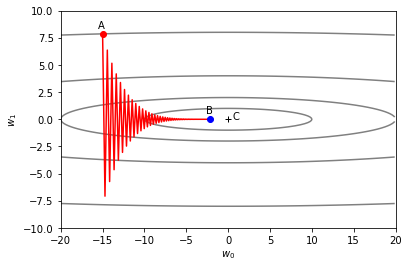

In [11]:

lim = 20
w0 = np.arange(-lim, lim, 0.1)
w1 = np.arange(-lim, lim, 0.1)
w0, w1 = np.meshgrid(w0,w1)
Z = a**2 *w0**2 +  w1**2
contours = plt.contour(w0,w1,Z,[1,4,16,64],colors='gray')
#plt.clabel(contours, fmt='%1d')

last = 100
plt.plot(path[:last+1,0], path[:last+1,1],'r-')
plt.plot(path[0,0], path[0,1],'ro') # start
plt.plot(path[last,0], path[last,1],'bo') # finish
plt.text(path[0,0]-0.5, path[0,1]+0.5, 'A')
plt.text(path[last,0]-0.5, path[last,1]+0.5, 'B')

plt.plot(0,0,'k+')
plt.text(0.5, 0, 'C')

plt.xlabel('$w_0$')
plt.ylabel('$w_1$')
plt.axis([-20,20,-10,10])
plt.savefig('no-momentum.png')


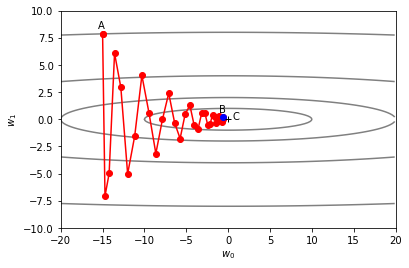

In [12]:
lim = 20
w0 = np.arange(-lim, lim, 0.1)
w1 = np.arange(-lim, lim, 0.1)
w0, w1 = np.meshgrid(w0,w1)
Z = a**2 *w0**2 +  w1**2
contours = plt.contour(w0,w1,Z,[1,4,16,64],colors='gray')
#plt.clabel(contours, fmt='%1d')

last = 30
plt.plot(pathm[:last+1,0], pathm[:last+1,1],'r-o')
plt.plot(pathm[0,0], pathm[0,1],'ro') # start
plt.plot(pathm[last,0], pathm[last,1],'bo') # finish
plt.text(pathm[0,0]-0.5, pathm[0,1]+0.5, 'A')
plt.text(pathm[last,0]-0.5, pathm[last,1]+0.5, 'B')

plt.plot(0,0,'k+')
plt.text(0.5, 0, 'C')

plt.xlabel('$w_0$')
plt.ylabel('$w_1$')
plt.axis([-20,20,-10,10])
plt.savefig('momentum.png')


In [13]:
momentum_coefs = [0, 0.5, 0.8, 0.9]
batch_size = 32
train_errors = {}
times = {}
step_size = 0.2
epochs = 50

    
for mom_coef in momentum_coefs:
    np.random.seed(3)
    tf.random.set_seed(3)    
    network = models.Sequential()
    network.add(layers.Dense(20, activation='relu', input_dim=2))
    network.add(layers.Dense(5, activation='relu'))
    network.add(layers.Dense(5, activation='relu'))
    network.add(layers.Dense(1, activation='sigmoid'))
    opt = optimizers.SGD(step_size, momentum = mom_coef)
    network.compile(optimizer=opt, loss='binary_crossentropy', metrics=['accuracy'])
    print('\n',mom_coef)
    history = network.fit(X_train,y_train, epochs=epochs, verbose = 0, batch_size=batch_size)
    train_errors[mom_coef] = history.history['loss']
print('Done')


 0

 0.5

 0.8

 0.9
Done


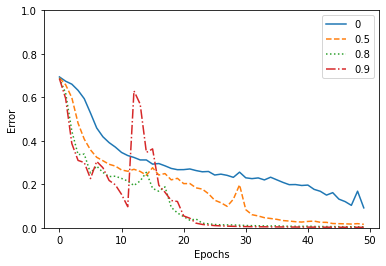

In [14]:
lines = plt.plot(np.array(list(train_errors.values())).transpose())
plt.xlabel('Epochs')
plt.ylabel('Error')
plt.ylim([0,1])
plt.legend(lines[:], momentum_coefs, loc='upper right')


plt.savefig('momenta.png')
plt.show();

## RMSProp ##

In [15]:
a = 0.1 # considering function z = a**2 *w0**2 +  w1**2
def f(w0, w1):
    global a
    return a**2 *w0**2 +  w1**2

num_steps = 100
step_size = 0.95 # This would be very large for a step size in a NN training setting, but this isn't a NN here

z = 64
w0 = -15
w1 = np.sqrt(z - a**2*w0**2)
S2 = 0

# without momentum
path = np.zeros((num_steps+1,2))
path[0,:] = np.array([w0, w1])

rms_coef = 0.99
for i in range(num_steps):
    current = path[i,:]
    dz  = np.array([2 *a**2 * current[0], 2 * current[1]])
    S2 = rms_coef * S2 + (1-rms_coef)*dz**2
    eps = 10**-8 # protection against division by zero
    scale = np.sqrt(S2) + eps
    nxt = current - step_size * (dz/scale)
    path[i+1,:] = nxt

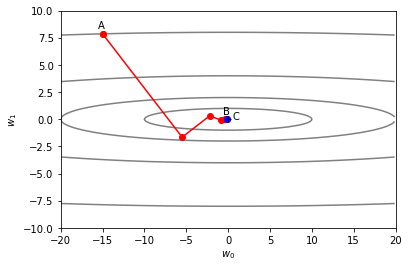

In [16]:
lim = 20
w0 = np.arange(-lim, lim, 0.1)
w1 = np.arange(-lim, lim, 0.1)
w0, w1 = np.meshgrid(w0,w1)
Z = a**2 *w0**2 +  w1**2
contours = plt.contour(w0,w1,Z,[1,4,16,64],colors='gray')
#plt.clabel(contours, fmt='%1d')

last = 5
plt.plot(path[:last+1,0], path[:last+1,1],'r-o')
plt.plot(path[0,0], path[0,1],'ro') # start
plt.plot(path[last,0], path[last,1],'bo') # finish
plt.text(path[0,0]-0.5, path[0,1]+0.5, 'A')
plt.text(path[last,0]-0.5, path[last,1]+0.5, 'B')

plt.plot(0,0,'k+')
plt.text(0.5, 0, 'C')

plt.xlabel('$w_0$')
plt.ylabel('$w_1$')
plt.axis([-20,20,-10,10])
plt.savefig('rms.png')

In [17]:
np.random.seed(3)
tf.random.set_seed(3)  
opts = (optimizers.SGD(0.2,0.8), optimizers.Adam(0.2))
opt_legend = ("SGD with momentum", "Adam")
batch_size = 32
train_errors = {}
times = {}
step_size = 0.2
epochs = 20

    
for run in range(2) :
    np.random.seed(3)
    tf.random.set_seed(3)    
    network = models.Sequential()
    network.add(layers.Dense(20, activation='relu', input_dim=2))
    network.add(layers.Dense(5, activation='relu'))
    network.add(layers.Dense(5, activation='relu'))
    network.add(layers.Dense(1, activation='sigmoid'))
    network.compile(optimizer=opts[run], loss='binary_crossentropy', metrics=['accuracy'])
    print(run)
    history = network.fit(X_train,y_train, epochs=epochs, verbose = 0, batch_size=batch_size)
    train_errors[run] = history.history['loss']
print('Done')

0
1
Done


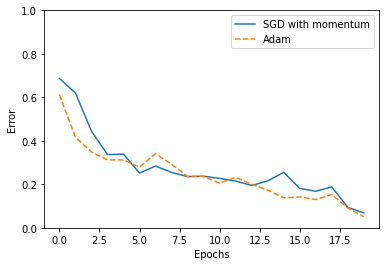

In [18]:
lines = plt.plot(np.array(list(train_errors.values())).transpose())
#plt.plot(train_errors)
plt.xlabel('Epochs')
plt.ylabel('Error')
plt.ylim([0,1])
plt.legend(lines[:], opt_legend, loc='upper right')

plt.savefig('adam.png')
plt.show();

## Initialization ##

In [19]:
inits = (initializers.Zeros(), initializers.RandomUniform(minval=-0.5, maxval=0.5, seed=1), \
         initializers.glorot_uniform(seed=1), initializers.he_uniform(seed=1))
init_legend = ('Zeros','Random uniform -0.5 to 0.5','Glorot uniform','He uniform')

In [20]:
train_errors = {}
for index, init in enumerate(inits):
    np.random.seed(3)
    tf.random.set_seed(3)    
    network = models.Sequential()
    network.add(layers.Dense(20,activation='relu', kernel_initializer=init, input_dim=2))
    network.add(layers.Dense(5, activation='relu', kernel_initializer=init))
    network.add(layers.Dense(5, activation='relu', kernel_initializer=init))
    network.add(layers.Dense(1, activation='sigmoid', kernel_initializer=init))
    opt=optimizers.Adam(0.1)
    print(init_legend[index])
    network.compile(optimizer=opt, loss='binary_crossentropy', metrics=['accuracy'])
    history = network.fit(X_train,y_train, epochs=30, verbose = 0)
    train_errors[init] = history.history['loss']
print('Done')

Zeros
Random uniform -0.5 to 0.5
Glorot uniform
He uniform
Done


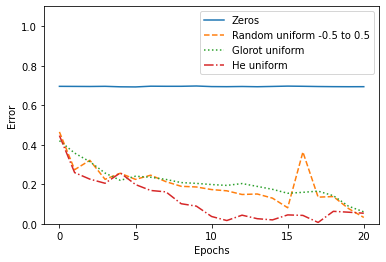

In [21]:
last = 20
plt.xticks([0,5,10,15,20])
lines = plt.plot(np.array(list(train_errors.values()))[:,:last+1].transpose())
#plt.plot(train_errors)
plt.xlabel('Epochs')
plt.ylabel('Error')
plt.ylim([0,1.1])

plt.legend(lines[:], init_legend, loc='upper right')
plt.savefig('initializers.png')
plt.show();

## Normalization ##

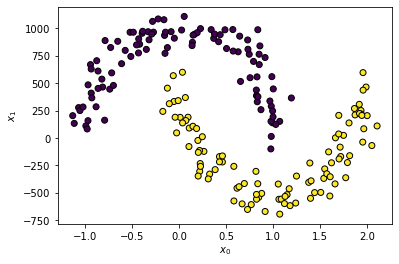

In [22]:
X_train1 = X_train*np.array([1,1000])
plt.scatter(X_train1[:, 0], X_train1[:, 1], marker='o', c=y_train, edgecolor='k')
plt.xlabel('$x_0$')
plt.ylabel('$x_1$');


In [23]:
## 1 ## Architecture
network = models.Sequential()
network.add(layers.Dense(20, activation='relu', input_dim=2))
network.add(layers.Dense(5, activation='relu'))
network.add(layers.Dense(5, activation='relu'))
network.add(layers.Dense(1, activation='sigmoid'))

## 2 ## Optimizer and Error function
opt = optimizers.Adam(0.1)
network.compile(optimizer=opt, loss='binary_crossentropy', metrics=['accuracy'])

## 3 ## Train
history_normalized = network.fit(X_train,y_train, epochs=100, verbose = 0)
print('Done')



Done


In [24]:
## 1 ## Architecture
network1 = models.Sequential()
network1.add(layers.Dense(20, activation='relu', input_dim=2))
network1.add(layers.Dense(5, activation='relu'))
network1.add(layers.Dense(5, activation='relu'))
network1.add(layers.Dense(1, activation='sigmoid'))

## 2 ## Optimizer and Error function
opt = optimizers.Adam(0.001) # step size decreased to enable convergence
network1.compile(optimizer=opt, loss='binary_crossentropy', metrics=['accuracy'])

## 3 ## Train
history_nonnormalized = network1.fit(X_train1,y_train, epochs=100, verbose = 0)
print('Done')

Done


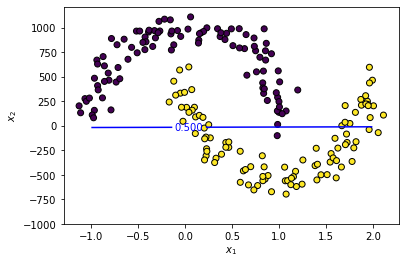

In [25]:
x0 = np.arange(-1.0,2.0,0.01)
x1 = np.arange(-1000, 1000, 10)
X0, X1 = np.meshgrid(x0,x1)
plotpoints = np.vstack((X0.flatten(), X1.flatten())).transpose() # convert X0, X1 to two column matrix
nn_output = network.predict(plotpoints).reshape(X0.shape) 
nn1_output = network1.predict(plotpoints).reshape(X0.shape)
contours = plt.contour(X0,X1,nn1_output,[0.5],cmap='brg')
plt.clabel(contours)

plt.scatter(X_train1[:, 0], X_train1[:, 1], marker='o', c=y_train, edgecolor='k')
plt.xlabel('$x_1$')
plt.ylabel('$x_2$');
plt.savefig('non_normalized.png')

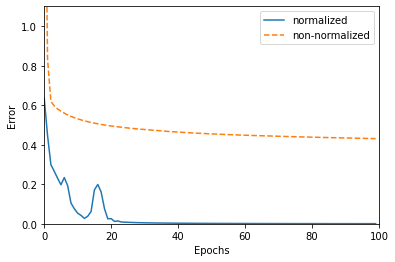

In [26]:
plt.plot(history_normalized.history['loss'])
plt.plot(history_nonnormalized.history['loss'])
plt.xlabel('Epochs')
plt.ylabel('Error')
plt.ylim([0,1.1]);
plt.xlim([0,100])
plt.legend(('normalized','non-normalized'), loc='upper right')
plt.savefig('normalization-errors.png')